# Implementation of the ETL method (Extract, Transform, Load)

## Extracting the Raw Data from the webpage
- First, import the libraries (pandas, requests, and BeautifulSoup)
- Choose a url (I chose a wikipedia page) and get the status code from the url
- If the code is 200, we can proceed with extracting data
- Next, parse wikipedia page with BeautifulSoup
- Find html with "table", and grab data from the 4th table (the one we want)
- Convert the raw data from the table to a pandas Dataframe

In [153]:
import pandas as pd 
import requests 
from bs4 import BeautifulSoup 
wikiurl="https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)
# parse wikipedia page with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')
# since there are multiple tables in the webpage, grab data from the 4th table (the one we want)
ustable=soup.find_all('table')[4]
raw_data=pd.read_html(str(ustable))
# convert raw data from table to dataframe
raw_data=pd.DataFrame(raw_data[0])
raw_data.head()

200


,2021rank,City,State[c],2021estimate,2020census,Change,2020 land area,2020 land area.1,2020 population density,2020 population density.1,Location
0,1,New York[d],New York,8467513,8804190,−3.82%,300.5 sq mi,778.3 km2,"29,298/sq mi","11,312/km2",".mw-parser-output .geo-default,.mw-parser-outp..."
1,2,Los Angeles,California,3849297,3898747,−1.27%,469.5 sq mi,"1,216.0 km2","8,304/sq mi","3,206/km2",34°01′N 118°25′W﻿ / ﻿34.02°N 118.41°W
2,3,Chicago,Illinois,2696555,2746388,−1.81%,227.7 sq mi,589.7 km2,"12,061/sq mi","4,657/km2",41°50′N 87°41′W﻿ / ﻿41.84°N 87.68°W
3,4,Houston,Texas,2288250,2304580,−0.71%,640.4 sq mi,"1,658.6 km2","3,599/sq mi","1,390/km2",29°47′N 95°23′W﻿ / ﻿29.79°N 95.39°W
4,5,Phoenix,Arizona,1624569,1608139,+1.02%,518.0 sq mi,"1,341.6 km2","3,105/sq mi","1,199/km2",33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W


## Save the noisy, Raw Data to CSV

In [154]:
raw_data.to_csv("WikiUSCitiesPopulationRaw.csv")

## Transforming the Data
- Create dataframe variable that will contain the final data, name it "final_data"
- Drop unnecessary columns from the table (I kept the columns with land area and population density in 2020 with units of km^2 and dropped the columns with data in sq miles and location)
- Rename the remaining columns names and check result by printing the head

In [155]:
# drop the unwanted columns
final_data = df.drop(["2020 population density", "Location","2020 land area"], axis=1)
# rename columns for ease
final_data = final_data.rename(columns={"State[c]": "State","Population(2011)[3]": "Population", "Change":"% Change", "2020 land area.1":"2020 land area (in km^2)","2020 population density.1": "2020 population density (per km^2)","2021estimate":"Pop Estimate (2021)", "2020census": "Pop Census (2020)", "2021rank":"City Rank in 2021"})
final_data.head()


,City Rank in 2021,City,State,Pop Estimate (2021),Pop Census (2020),% Change,2020 land area (in km^2),2020 population density (per km^2)
0,1,New York[d],New York,8467513,8804190,−3.82%,778.3 km2,"11,312/km2"
1,2,Los Angeles,California,3849297,3898747,−1.27%,"1,216.0 km2","3,206/km2"
2,3,Chicago,Illinois,2696555,2746388,−1.81%,589.7 km2,"4,657/km2"
3,4,Houston,Texas,2288250,2304580,−0.71%,"1,658.6 km2","1,390/km2"
4,5,Phoenix,Arizona,1624569,1608139,+1.02%,"1,341.6 km2","1,199/km2"


## Perform Duplication checks on the data

In [156]:
number_of_duplicates = final_data.duplicated().sum()
print (f" Number of duplicates before : {number_of_duplicates}")


final_data = final_data.drop_duplicates()

number_of_duplicates = final_data.duplicated().sum()
print (f" Number of duplicates after removing : {number_of_duplicates}")

 Number of duplicates before : 0
 Number of duplicates after removing : 0


## Inspecting the data for noisy entries

In [157]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 330
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   City Rank in 2021                   331 non-null    int64 
 1   City                                331 non-null    object
 2   State                               331 non-null    object
 3   Pop Estimate (2021)                 331 non-null    int64 
 4   Pop Census (2020)                   331 non-null    int64 
 5   % Change                            329 non-null    object
 6   2020 land area (in km^2)            331 non-null    object
 7   2020 population density (per km^2)  331 non-null    object
dtypes: int64(3), object(5)
memory usage: 23.3+ KB


## Drop the null entries

In [158]:
final_data = final_data.dropna()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 0 to 330
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   City Rank in 2021                   329 non-null    int64 
 1   City                                329 non-null    object
 2   State                               329 non-null    object
 3   Pop Estimate (2021)                 329 non-null    int64 
 4   Pop Census (2020)                   329 non-null    int64 
 5   % Change                            329 non-null    object
 6   2020 land area (in km^2)            329 non-null    object
 7   2020 population density (per km^2)  329 non-null    object
dtypes: int64(3), object(5)
memory usage: 23.1+ KB


## Perform cleaning by removing unnecessary strings from numerical data

In [159]:
def convert_strings_to_float(s):
    s = s.replace("%","")
    s = s.replace("−","-")
    s = s.replace("km2","")
    s = s.replace(",","")
    s = s.replace("/","")
    converted = float(s)
    return converted

final_data["2020 population density (per km^2)"] = final_data["2020 population density (per km^2)"].apply(convert_strings_to_float)
final_data["2020 land area (in km^2)"] = final_data["2020 land area (in km^2)"].apply(convert_strings_to_float)
final_data["% Change"] = final_data["% Change"].apply(convert_strings_to_float)

final_data.head()


,City Rank in 2021,City,State,Pop Estimate (2021),Pop Census (2020),% Change,2020 land area (in km^2),2020 population density (per km^2)
0,1,New York[d],New York,8467513,8804190,-3.82,778.3,11312.0
1,2,Los Angeles,California,3849297,3898747,-1.27,1216.0,3206.0
2,3,Chicago,Illinois,2696555,2746388,-1.81,589.7,4657.0
3,4,Houston,Texas,2288250,2304580,-0.71,1658.6,1390.0
4,5,Phoenix,Arizona,1624569,1608139,1.02,1341.6,1199.0


## Load the clean, Final Data to csv


In [160]:
final_data.to_csv("WikiUSCitiesPopulationFinal.csv")

# Data Analysis and Visualization
- Now that the data is cleaned, we can start to analyze the data
- Here are the Descriptive Statistics for the attribute "Pop Census (2020)"

In [33]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import pylab as pl

InteractiveShell.ast_node_interactivity = "all"


uspopulation_df = pd.read_csv("WikiUSCitiesPopulationFinal.csv")
pop_census = uspopulation_df["Pop Census (2020)"]
pop_census.describe()


count    3.290000e+02
mean     2.954106e+05
std      5.893331e+05
min      9.150200e+04
25%      1.169610e+05
50%      1.566070e+05
75%      2.638860e+05
max      8.804190e+06
Name: Pop Census (2020), dtype: float64

### Insights

- The average population from the 2020 census for the top 329 most populated cities in the US was 2.95 * 10^5
- The min or lowest population from the 2020 census for the top 329 most populated cities in the US was 9.15 * 10^4
- The max or highest population from the 2020 census for the top 329 most populated cities in the US was 8.8 * 10^6
- The standard deviation from the 2020 population census for the top 329 most populated cities in the US was 5.89 * 10^5
- The IQR (75%-25%) from the 2020 population census for the top 329 most populated cities in the US was 1.47 * 10^5




## Histogram 

<AxesSubplot:>

Text(0.5, 0.98, 'Population Census for US Cities (2020)')

Text(0.5, 0, ' US Cities Population Census (2020)')

Text(0, 0.5, 'Frequency')

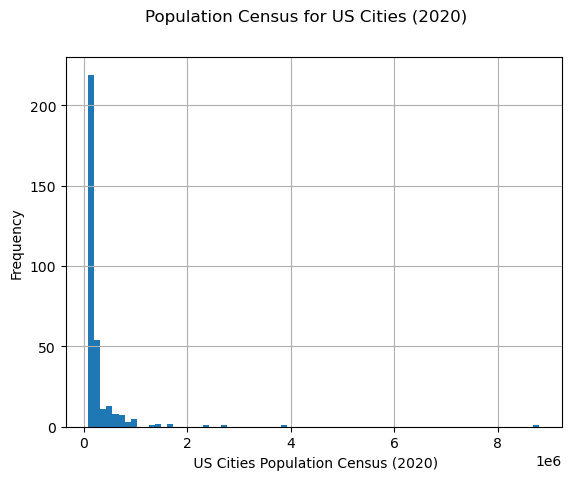

In [39]:
pop_census.hist(bins=75)
pl.suptitle("Population Census for US Cities (2020)")
pl.xlabel(" US Cities Population Census (2020)")
pl.ylabel("Frequency")

### Insights
- With 75 bins, the data appears to be skewed right
- Median and IQR are recommended measures of center and spread

# Boxplot 

{'whiskers': [<matplotlib.lines.Line2D at 0x1bec03e53a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1bec03e5940>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bec03e5130>],
 'medians': [<matplotlib.lines.Line2D at 0x1bec03e5ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bec03f21f0>],
 'means': []}

Text(0.5, 0, 'Population Census for US Cities (2020)')

Text(0, 0.5, 'Population')

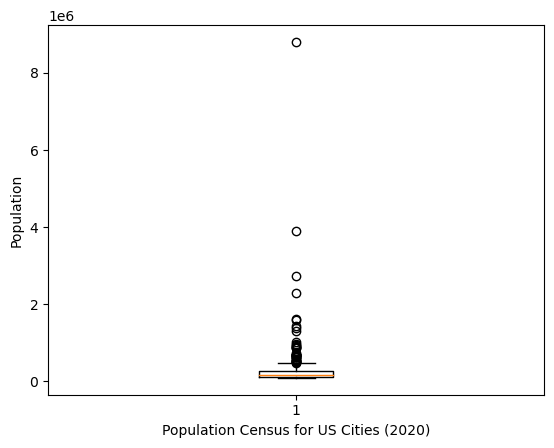

In [40]:
plt.boxplot(pop_census)

plt.xlabel("Population Census for US Cities (2020)")
plt.ylabel("Population")

## Insights from Boxplot
- There are outliers both mainly above the boxplot
- The distribution of the data is not normal


# Bar Chart

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'City')

Text(0, 0.5, 'Pop Census (2020)')

Text(0.5, 1.0, 'Pop Census (2020) and US Cities (Top 10)')

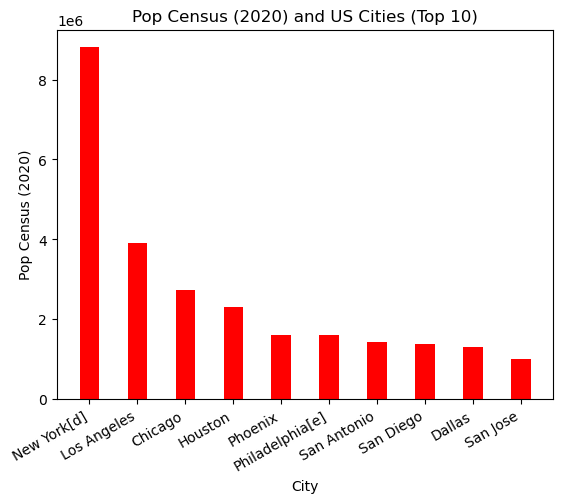

In [31]:
# Use a bar chart for plotting gross vs director_name
x_column = uspopulation_df["City"]
y_column = uspopulation_df["Pop Census (2020)"]

selected_x = []
selected_y = []

for rows in range(10):
    selected_x.append(x_column[rows])
    selected_y.append(y_column[rows])
    

# Now plot our bar graph
plt.bar(selected_x, selected_y, color ='red', width =.4)
plt.xticks(rotation=30, ha='right')


plt.xlabel("City")
plt.ylabel("Pop Census (2020)")
plt.title("Pop Census (2020) and US Cities (Top 10)")

### Insights
- Compared to the other cities, in 2020, New York has the greatest population in the US, by a huge difference, which shows the reason for why the data was skewed
- In Texas, Houston has a greater population than San Antonio and Dallas
- In California, Los Angeles (the second highest populated city) has a significantly larger population than San Diego and San Jose
- The bar graph shows that most of the cities that are have a high population are from Texas and California 